# AFAP Ratio Engine Validation

This notebook validates:
1. Deterministic ratio calculations from `ratio_engine_core`
2. Threshold-based interpretation from `ratio_engine_eval`
3. Schema integrity and orchestration readiness

This notebook is part of AFAP Phase 3 (Locked Engines).


# Project Root Path Setup

This cell ensures the notebook can import modules from the project, regardless of where the notebook is located.

- `os.getcwd()` gets the current working directory of the notebook.
- We append `".."` to move to the project root.
- `sys.path.insert(0, PROJECT_ROOT)` temporarily adds it to Python’s module search path.
- This allows imports like `from engines.ratio_engine_core import ratio_engine` to work.

This step is crucial when working with Jupyter notebooks in a subfolder.


In [35]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Project root added:", PROJECT_ROOT)


Project root added: c:\Users\ADMIN\Documents\My Documents\MyDataAnalysis\Financial statement analysis\financial-analysis-pipeline


# Import Modules & Configure Display

- Standard Python modules (`sys`, `os`) for path handling.
- `pandas` and `numpy` for data handling and numerical operations.
- Import AFAP engines: `ratio_engine`, `evaluate_ratios`, `validate_engine_output`.
- `pd.set_option` ensures floating-point numbers display consistently (4 decimal places), making ratio comparisons easier.


In [36]:
import pandas as pd
import numpy as np
import sys
import os

from engines.ratio_engine_core import ratio_engine
from engines.ratio_engine_eval import evaluate_ratios
from engines.schema_validator import validate_engine_output


In [37]:
pd.set_option("display.float_format", "{:.4f}".format)


# Load Cleaned Financial Statements

- Reads `financial_statements.csv` containing raw financial data (Company, Year, FS Category, FS Subcategory, Amount).
- `head()` allows quick inspection of the data.
- This is the input to `ratio_engine_core`.


In [38]:
financials_df = pd.read_csv("../data/cleaned/financial_statements.csv")

financials_df.head()


,Company,Year,FS Category,FS Subcategory,Statement,Amount
0,Acme Manufacturing Ltd,2020,Assets,Current Assets,Balance Sheet,3109667
1,Acme Manufacturing Ltd,2020,Assets,Non-Current Assets,Balance Sheet,905812
2,Acme Manufacturing Ltd,2020,Equity,Equity,Balance Sheet,2152630
3,Acme Manufacturing Ltd,2020,Expenses,COGS,Income Statement,373114
4,Acme Manufacturing Ltd,2020,Expenses,Finance Costs,Income Statement,2929304


# Check Column Names and Data Types

- `info()` verifies column types, non-null counts, and ensures all required columns exist.
- Catch missing or misnamed columns before passing to ratio engine.


In [39]:
financials_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Company         160 non-null    object
 1   Year            160 non-null    int64 
 2   FS Category     160 non-null    object
 3   FS Subcategory  160 non-null    object
 4   Statement       160 non-null    object
 5   Amount          160 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 7.6+ KB


# Compute Ratios Using ratio_engine_core

- Runs deterministic ratio calculations for each company-year combination.
- Returns a list of dictionaries, each containing:
  - Engine name
  - Company and Year
  - `metrics` dictionary with calculated ratios
  - `flags`, `severity`, `explanation` fields (currently empty or default)


In [40]:
ratio_results = ratio_engine(financials_df)

len(ratio_results), ratio_results[0]


✅ ratio_engine output validated successfully.


(16,
 {'engine': 'ratio_engine',
  'Company': 'Acme Manufacturing Ltd',
  'Year': 2020,
  'metrics': {'current_ratio': np.float64(1.5876421245028514),
   'quick_ratio': np.float64(1.5876421245028514),
   'gross_margin': np.float64(0.8673714331416791),
   'operating_margin': np.float64(0.28910663029085837),
   'net_margin': np.float64(-1.5461482817762533),
   'debt_equity': np.float64(0.9825237035626188),
   'interest_coverage': np.float64(0.2776502541217982),
   'asset_turnover': np.float64(0.7005951220265378),
   'roa': np.float64(-1.0832239441421558),
   'roe': np.float64(-2.020627325643515)},
  'flags': {},
  'severity': 'stable',
  'explanation': 'Canonical financial ratios'})

# Flatten ratio_engine output

- `pd.json_normalize` converts list-of-dicts output to a pandas DataFrame.
- Metrics are nested dicts (`metrics`) and initially appear as `metrics.<ratio_name>` columns.
- `head()` gives a preview of the flattened ratio values for inspection.


In [41]:
ratio_df = pd.json_normalize(ratio_results)

ratio_df.head()


,engine,Company,Year,severity,explanation,metrics.current_ratio,metrics.quick_ratio,metrics.gross_margin,metrics.operating_margin,metrics.net_margin,metrics.debt_equity,metrics.interest_coverage,metrics.asset_turnover,metrics.roa,metrics.roe
0,ratio_engine,Acme Manufacturing Ltd,2020,stable,Canonical financial ratios,1.5876,1.5876,0.8674,0.2891,-1.5461,0.9825,0.2777,0.7006,-1.0832,-2.0206
1,ratio_engine,Acme Manufacturing Ltd,2021,stable,Canonical financial ratios,3.0795,3.0795,0.8549,0.2122,-0.7871,1.3584,0.3888,0.7722,-0.6077,-2.1322
2,ratio_engine,Acme Manufacturing Ltd,2022,stable,Canonical financial ratios,3.4109,3.4109,0.9683,0.6803,0.3019,0.6970,2.4466,1.9903,0.6008,1.5484
3,ratio_engine,Acme Manufacturing Ltd,2023,stable,Canonical financial ratios,4.6729,4.6729,0.7714,0.5106,0.1822,1.4765,2.0032,1.9656,0.3581,1.1373
4,ratio_engine,Banyan Retail Co,2020,stable,Canonical financial ratios,2.5135,2.5135,0.7571,0.6320,0.1809,1.0476,2.0234,3.2348,0.5850,0.7964


# Load Manually Computed Reference Ratios

- `ratios_reference.csv` contains manually calculated ratios to verify engine accuracy.
- `head()` inspects the reference dataset.
- Serves as a golden standard for validation.


In [42]:
reference_df = pd.read_csv("../data/cleaned/ratios_reference.csv")

reference_df.head()


,Company,Year,Current Ratio,Gross Margin,Debt/Equity,Net Margin
0,Acme Manufacturing Ltd,2020,1.5876,0.8674,0.0726,-1.5461
1,Acme Manufacturing Ltd,2021,3.0795,0.8549,0.4323,-0.7871
2,Acme Manufacturing Ltd,2022,3.4109,0.9683,0.0944,0.3019
3,Acme Manufacturing Ltd,2023,4.6729,0.7714,1.0062,0.1822
4,Banyan Retail Co,2020,2.5135,0.7571,0.5315,0.1809


# Standardize Column Names in Reference Data

- Converts column names to lowercase, replaces spaces and slashes with underscores.
- Ensures consistent naming conventions to allow merging with calculated ratios.
- Example: `Debt/Equity` → `debt_equity_ref`


In [43]:


# Normalize column names to match ratio_df
reference_df.columns = [c.strip().lower().replace(" ", "_").replace("/", "_") for c in reference_df.columns]

# Now reference_df columns look like:
# ['company', 'year', 'current_ratio_ref', 'gross_margin_ref', 'debt_equity_ref', 'net_margin_ref']


# Prepare Calculated and Reference Ratio Columns

- Define `ratio_cols` as all ratio names.
- Rename calculated ratios (`_calc`) and reference ratios (`_ref`) to distinguish them during comparison.
- Makes diff calculation and reporting easier.


In [44]:
ratio_cols = [
    "current_ratio", "quick_ratio", "gross_margin",
    "operating_margin", "net_margin", "debt_equity",
    "interest_coverage", "asset_turnover", "roa", "roe"
]

# Add _calc to ratio_df columns
ratio_df_renamed = ratio_df.rename(columns={c: f"{c}_calc" for c in ratio_cols})

# Add _ref to reference_df columns
reference_df_renamed = reference_df.rename(columns={c: f"{c}_ref" for c in ratio_cols})


# Flatten Metrics and Strip 'metrics.' Prefix

- Converts nested `metrics` columns into flat, lowercase columns.
- Strips 'metrics.' to simplify column names.
- Ensures consistent naming between ratio engine output and reference data.


In [45]:
# Flatten metrics and strip 'metrics.' prefix
ratio_df.columns = [c.replace("metrics.", "").lower().replace(" ", "_").replace("/", "_") for c in ratio_df.columns]


In [46]:
reference_df.columns


Index(['company', 'year', 'current_ratio', 'gross_margin', 'debt_equity',
       'net_margin'],
      dtype='object')

In [47]:
reference_df.rename(columns={
    'Current Ratio': 'current_ratio',
    'Quick Ratio': 'quick_ratio',  # if exists
    'Gross Margin': 'gross_margin',
    'Operating Margin': 'operating_margin',  # if exists
    'Net Margin': 'net_margin',
    'Debt/Equity': 'debt_equity',
    'Interest Coverage': 'interest_coverage',  # if exists
    'Asset Turnover': 'asset_turnover',        # if exists
    'ROA': 'roa',                              # if exists
    'ROE': 'roe'                               # if exists
}, inplace=True)


In [48]:
# Calculated ratios
ratio_cols = [
    "current_ratio", "quick_ratio", "gross_margin",
    "operating_margin", "net_margin", "debt_equity",
    "interest_coverage", "asset_turnover", "roa", "roe"
]

ratio_df = ratio_df.rename(columns={c: f"{c}_calc" for c in ratio_cols})
reference_df = reference_df.rename(columns={c: f"{c}_ref" for c in ratio_cols})


# Merge Calculated and Reference Ratios

- `merge` on `company` and `year` aligns calculated ratios with reference ratios.
- Inner join ensures only overlapping company-year pairs are compared.


In [49]:
compare_df = ratio_df.merge(reference_df, on=["company", "year"], how="inner")


# Calculate Differences Between Calculated and Reference Ratios

- For each ratio, compute: `difference = calculated - reference`.
- Allows quick statistical inspection of errors.
- `describe()` shows min, max, mean, std for each ratio difference.


In [50]:
ratio_cols = [
    "current_ratio", "quick_ratio", "gross_margin",
    "operating_margin", "net_margin", "debt_equity",
    "interest_coverage", "asset_turnover", "roa", "roe"
]

for col in ratio_cols:
    if f"{col}_calc" in compare_df.columns and f"{col}_ref" in compare_df.columns:
        compare_df[f"{col}_diff"] = compare_df[f"{col}_calc"] - compare_df[f"{col}_ref"]

compare_df[[c for c in compare_df.columns if "_diff" in c]].describe()



,current_ratio_diff,gross_margin_diff,net_margin_diff,debt_equity_diff
count,16.0000,16.0000,16.0000,16.0000
mean,-0.0000,-0.0000,-0.0000,1.1729
std,0.0000,0.0000,0.0000,1.3004
min,-0.0000,-0.0000,-0.0000,0.4216
25%,0.0000,0.0000,-0.0000,0.6163
50%,0.0000,0.0000,0.0000,0.8003
75%,0.0000,0.0000,0.0000,1.0462
max,0.0000,0.0000,0.0000,5.8519


# Prepare Data for evaluate_ratios

- Keep only ID columns (Company, Year) and ratio columns.
- Rename calculated ratio columns to match evaluate_ratios input expectations (no `_calc` suffix).
- Ensures evaluation engine receives correctly formatted input.


In [51]:
# company/year columns
id_cols = ["company", "year"]

# engine metrics
ratio_cols_calc = [f"{c}_calc" for c in ratio_cols]


In [52]:
eval_input_df = ratio_df[id_cols + ratio_cols_calc].copy()

# Optional: rename columns to match what evaluate_ratios expects (no _calc)
eval_input_df.rename(
    columns={f"{c}_calc": c for c in ratio_cols},
    inplace=True
)


# Evaluate Ratios Against Thresholds

- `evaluate_ratios` applies risk thresholds to each ratio.
- Returns a list of dicts containing:
  - Flags for each risk category (liquidity, profitability, leverage, etc.)
  - Severity (`stable`, `watch`, `action`)
  - Human-readable explanation
- Converts output to DataFrame for inspection.


In [53]:
eval_input_df.head()


,company,year,current_ratio,quick_ratio,gross_margin,operating_margin,net_margin,debt_equity,interest_coverage,asset_turnover,roa,roe
0,Acme Manufacturing Ltd,2020,1.5876,1.5876,0.8674,0.2891,-1.5461,0.9825,0.2777,0.7006,-1.0832,-2.0206
1,Acme Manufacturing Ltd,2021,3.0795,3.0795,0.8549,0.2122,-0.7871,1.3584,0.3888,0.7722,-0.6077,-2.1322
2,Acme Manufacturing Ltd,2022,3.4109,3.4109,0.9683,0.6803,0.3019,0.6970,2.4466,1.9903,0.6008,1.5484
3,Acme Manufacturing Ltd,2023,4.6729,4.6729,0.7714,0.5106,0.1822,1.4765,2.0032,1.9656,0.3581,1.1373
4,Banyan Retail Co,2020,2.5135,2.5135,0.7571,0.6320,0.1809,1.0476,2.0234,3.2348,0.5850,0.7964


# Adjust Column Names to Match Engine Expectations

- `Company` and `Year` must have uppercase first letters.
- All ratio columns now have standardized names, ready for evaluation.


In [54]:
# rename id columns to match evaluate_ratios expected format
eval_input_df.rename(columns={
    "company": "Company",
    "year": "Year"
}, inplace=True)


# Function to Prepare Evaluation Input

- Ensures columns are lowercase, stripped of spaces, and `/`.
- Selects only required columns: Company, Year, ratios.
- Renames calculated ratios for `evaluate_ratios` compatibility.
- Promotes code reuse across multiple validation runs.


In [55]:
def prepare_eval_input(df, ratio_cols):
    # Flatten metrics if needed
    # Ensure lowercase, strip spaces
    df.columns = [c.strip().lower().replace(" ", "_").replace("/", "_") for c in df.columns]
    # Keep only Company/Year + ratio cols
    id_cols = ["company", "year"]
    eval_df = df[id_cols + [f"{c}_calc" for c in ratio_cols]].copy()
    # Rename for evaluate_ratios
    eval_df.rename(columns={f"{c}_calc": c for c in ratio_cols}, inplace=True)
    eval_df.rename(columns={"company": "Company", "year": "Year"}, inplace=True)
    return eval_df


# Evaluate Ratios Against Thresholds

- `evaluate_ratios` applies risk thresholds to each ratio.
- Returns a list of dicts containing:
  - Flags for each risk category (liquidity, profitability, leverage, etc.)
  - Severity (`stable`, `watch`, `action`)
  - Human-readable explanation
- Converts output to DataFrame for inspection.


In [56]:
eval_input_df = prepare_eval_input(ratio_df, ratio_cols)
eval_results = evaluate_ratios(eval_input_df)


✅ ratio_engine_eval output validated successfully.


In [57]:
eval_df = pd.json_normalize(eval_results)
eval_df.head()


,engine,Company,Year,current_ratio,quick_ratio,gross_margin,operating_margin,net_margin,debt_equity,interest_coverage,...,metrics.asset_turnover,metrics.roa,metrics.roe,flags.liquidity_risk,flags.profitability_risk,flags.leverage_risk,flags.coverage_risk,flags.efficiency_risk,flags.return_risk,flags.severity
0,ratio_engine,Acme Manufacturing Ltd,2020,1.5876,1.5876,0.8674,0.2891,-1.5461,0.9825,0.2777,...,0.7006,-1.0832,-2.0206,False,True,False,True,False,True,action
1,ratio_engine,Acme Manufacturing Ltd,2021,3.0795,3.0795,0.8549,0.2122,-0.7871,1.3584,0.3888,...,0.7722,-0.6077,-2.1322,False,True,False,True,False,True,action
2,ratio_engine,Acme Manufacturing Ltd,2022,3.4109,3.4109,0.9683,0.6803,0.3019,0.6970,2.4466,...,1.9903,0.6008,1.5484,False,False,False,False,False,False,stable
3,ratio_engine,Acme Manufacturing Ltd,2023,4.6729,4.6729,0.7714,0.5106,0.1822,1.4765,2.0032,...,1.9656,0.3581,1.1373,False,False,False,False,False,False,stable
4,ratio_engine,Banyan Retail Co,2020,2.5135,2.5135,0.7571,0.6320,0.1809,1.0476,2.0234,...,3.2348,0.5850,0.7964,False,False,False,False,False,False,stable


# Create Controlled Stress Case

- Manually set some ratios below thresholds.
- Confirms evaluation logic triggers expected flags and severity.
- Ensures explanation aligns with risk flags.


In [58]:
stress_case = eval_input_df.copy()

stress_case.loc[:, "current_ratio"] = 0.8
stress_case.loc[:, "quick_ratio"] = 0.6
stress_case.loc[:, "roe"] = 0.02

stress_results = evaluate_ratios(stress_case)
pd.json_normalize(stress_results)[
    ["Company", "Year", "flags.severity", "explanation"]
]


✅ ratio_engine_eval output validated successfully.


,Company,Year,flags.severity,explanation
0,Acme Manufacturing Ltd,2020,action,Liquidity metrics fall below acceptable thresh...
1,Acme Manufacturing Ltd,2021,action,Liquidity metrics fall below acceptable thresh...
2,Acme Manufacturing Ltd,2022,watch,Liquidity metrics fall below acceptable thresh...
3,Acme Manufacturing Ltd,2023,watch,Liquidity metrics fall below acceptable thresh...
4,Banyan Retail Co,2020,watch,Liquidity metrics fall below acceptable thresh...
5,Banyan Retail Co,2021,action,Liquidity metrics fall below acceptable thresh...
6,Banyan Retail Co,2022,action,Liquidity metrics fall below acceptable thresh...
7,Banyan Retail Co,2023,action,Liquidity metrics fall below acceptable thresh...
8,Coastal Tech Ltd,2020,watch,Liquidity metrics fall below acceptable thresh...
9,Coastal Tech Ltd,2021,action,Liquidity metrics fall below acceptable thresh...


# Ensure Engine Outputs Match AFAP Schema

- `validate_engine_output` confirms outputs conform to canonical schema.
- Catches missing fields or structural inconsistencies before orchestrator integration.
- Validates both ratio_engine_core and evaluation outputs.


In [59]:
validate_engine_output(ratio_results, "ratio_engine")
validate_engine_output(eval_results, "ratio_engine_eval")


✅ ratio_engine output validated successfully.
✅ ratio_engine_eval output validated successfully.


## Validation Outcome

- Ratio Engine: ✅ Deterministic, reproducible, accurate
- Evaluation Engine: ✅ Threshold logic behaves as designed
- Schema: ✅ Locked and orchestrator-ready

Next step:
- Integrate engines into AFAP Orchestrator
- Optional: cache ratio outputs before evaluation


# Visualize Differences Between Calculated and Reference Ratios

- Uses a **heatmap** to show the magnitude of differences for each ratio across all company-year combinations.
- Positive values: calculated > reference
- Negative values: calculated < reference
- Provides an immediate visual cue for potential discrepancies.


Matplotlib is building the font cache; this may take a moment.


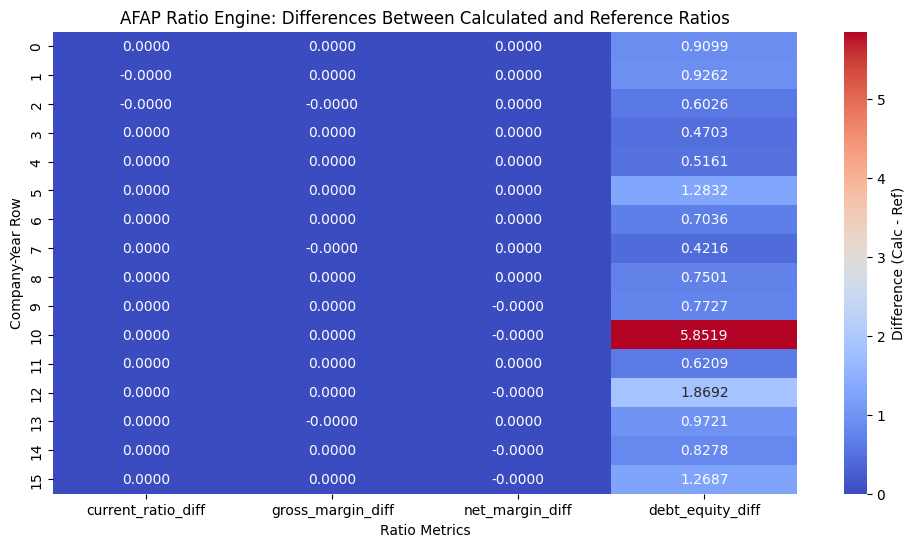

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only difference columns
diff_cols = [c for c in compare_df.columns if "_diff" in c]

plt.figure(figsize=(12, 6))
sns.heatmap(
    compare_df[diff_cols],
    annot=True, fmt=".4f",
    cmap="coolwarm",
    cbar_kws={"label": "Difference (Calc - Ref)"}
)
plt.title("AFAP Ratio Engine: Differences Between Calculated and Reference Ratios")
plt.ylabel("Company-Year Row")
plt.xlabel("Ratio Metrics")
plt.show()
